# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline

import torch
import numpy as np
from torch import optim
import torchvision.utils
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split

import config
from utils import imshow
from models import SiameseNetwork
from training import trainSiamese,inferenceSiamese
from datasets import SiameseNetworkDataset
from loss_functions import ContrastiveLoss

# generate_csv(config.training_dir)

import os
if not os.path.exists('state_dict'):
    os.makedirs('state_dict')

## Using Image Folder Dataset

In [2]:
siamese_dataset = SiameseNetworkDataset(config.siamese_training_csv,
                                        transform=transforms.Compose([
                                            transforms.Resize((config.img_height,config.img_width)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(0,1)]),
                                        should_invert=False)

../../datasets/AT&T Database of Faces/faces/training/siamese_train_data.csv


## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

In [3]:
# vis_dataloader = DataLoader(siamese_dataset,
#                         shuffle=True,
#                         num_workers=1,
#                         batch_size=8)

# dataiter = iter(vis_dataloader)

# example_batch = next(dataiter)

# concatenated = torch.cat((example_batch[0],example_batch[1]),0)
# imshow(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

## Training Time!

In [4]:
# Split the dataset into train, validation and test sets
num_train = round(0.9*siamese_dataset.__len__())
num_validate = siamese_dataset.__len__()-num_train
siamese_train, siamese_valid = random_split(siamese_dataset, [num_train,num_validate])
train_dataloader = DataLoader(siamese_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=config.train_batch_size)
valid_dataloader = DataLoader(siamese_valid,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)

In [5]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = config.learning_rate )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,config.step_size, config.gamma)

Epoch  0  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00,  8.57it/s]


Epoch  0  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 223.01it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:1.23	 min:0.16	 mean:0.47	 median 0.43
-1 features max:1.52	 min:0.35	 mean:0.77	 median 0.72
Feature = 0	Threshold = 0.525205	Polorization = 1
Epoch-0	 Train loss: 0.1299	 Valid loss: 0.1146	 Valid error: 0.1790
Epoch  1  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.84it/s]


Epoch  1  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 227.75it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.47	 min:0.10	 mean:0.20	 median 0.18
-1 features max:0.66	 min:0.15	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.232860	Polorization = 1
Epoch-1	 Train loss: 0.0187	 Valid loss: 0.0198	 Valid error: 0.1420
new model saved
Epoch  2  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.89it/s]


Epoch  2  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 223.56it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.37	 min:0.06	 mean:0.13	 median 0.12
-1 features max:0.55	 min:0.11	 mean:0.29	 median 0.29
Feature = 0	Threshold = 0.192041	Polorization = 1
Epoch-2	 Train loss: 0.0052	 Valid loss: 0.0090	 Valid error: 0.0679
new model saved
Epoch  3  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.81it/s]


Epoch  3  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 210.33it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.24	 min:0.04	 mean:0.11	 median 0.10
-1 features max:0.52	 min:0.12	 mean:0.29	 median 0.29
Feature = 0	Threshold = 0.172829	Polorization = 1
Epoch-3	 Train loss: 0.0024	 Valid loss: 0.0063	 Valid error: 0.0432
new model saved
Epoch  4  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.86it/s]


Epoch  4  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 215.21it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.21	 min:0.04	 mean:0.10	 median 0.09
-1 features max:0.53	 min:0.14	 mean:0.31	 median 0.30
Feature = 0	Threshold = 0.159119	Polorization = 1
Epoch-4	 Train loss: 0.0011	 Valid loss: 0.0053	 Valid error: 0.0278
new model saved
Epoch  5  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.82it/s]


Epoch  5  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 219.17it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.22	 min:0.04	 mean:0.09	 median 0.09
-1 features max:0.52	 min:0.15	 mean:0.31	 median 0.31
Feature = 0	Threshold = 0.168617	Polorization = 1
Epoch-5	 Train loss: 0.0013	 Valid loss: 0.0047	 Valid error: 0.0185
new model saved
Epoch  6  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.64it/s]


Epoch  6  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 218.74it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.22	 min:0.03	 mean:0.09	 median 0.08
-1 features max:0.53	 min:0.16	 mean:0.32	 median 0.32
Feature = 0	Threshold = 0.178403	Polorization = 1
Epoch-6	 Train loss: 0.0007	 Valid loss: 0.0045	 Valid error: 0.0154
new model saved
Epoch  7  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.87it/s]


Epoch  7  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 228.78it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.21	 min:0.03	 mean:0.09	 median 0.08
-1 features max:0.54	 min:0.16	 mean:0.32	 median 0.32
Feature = 0	Threshold = 0.161314	Polorization = 1
Epoch-7	 Train loss: 0.0009	 Valid loss: 0.0043	 Valid error: 0.0154
new model saved
Epoch  8  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.87it/s]


Epoch  8  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 220.37it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.21	 min:0.03	 mean:0.08	 median 0.08
-1 features max:0.53	 min:0.16	 mean:0.33	 median 0.32
Feature = 0	Threshold = 0.157846	Polorization = 1
Epoch-8	 Train loss: 0.0005	 Valid loss: 0.0041	 Valid error: 0.0154
new model saved
Epoch  9  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.69it/s]


Epoch  9  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 223.57it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.21	 min:0.02	 mean:0.08	 median 0.08
-1 features max:0.54	 min:0.17	 mean:0.33	 median 0.33
Feature = 0	Threshold = 0.179234	Polorization = 1
Epoch-9	 Train loss: 0.0003	 Valid loss: 0.0040	 Valid error: 0.0123
new model saved
Epoch  10  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.70it/s]


Epoch  10  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 226.83it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.21	 min:0.02	 mean:0.08	 median 0.08
-1 features max:0.54	 min:0.18	 mean:0.33	 median 0.32
Feature = 0	Threshold = 0.175047	Polorization = 1
Epoch-10	 Train loss: 0.0006	 Valid loss: 0.0039	 Valid error: 0.0093
new model saved
Epoch  11  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.98it/s]


Epoch  11  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 216.47it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.02	 mean:0.08	 median 0.08
-1 features max:0.55	 min:0.17	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.174255	Polorization = 1
Epoch-11	 Train loss: 0.0003	 Valid loss: 0.0039	 Valid error: 0.0123
new model saved
Epoch  12  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.75it/s]


Epoch  12  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 231.00it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.02	 mean:0.08	 median 0.07
-1 features max:0.56	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.169969	Polorization = 1
Epoch-12	 Train loss: 0.0003	 Valid loss: 0.0037	 Valid error: 0.0123
new model saved
Epoch  13  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.79it/s]


Epoch  13  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 221.37it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.21	 min:0.02	 mean:0.08	 median 0.08
-1 features max:0.55	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.181160	Polorization = 1
Epoch-13	 Train loss: 0.0005	 Valid loss: 0.0038	 Valid error: 0.0093
new model saved
Epoch  14  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.81it/s]


Epoch  14  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 212.06it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.02	 mean:0.08	 median 0.07
-1 features max:0.59	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.169086	Polorization = 1
Epoch-14	 Train loss: 0.0004	 Valid loss: 0.0036	 Valid error: 0.0093
new model saved
Epoch  15  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.67it/s]


Epoch  15  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 216.96it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.02	 mean:0.08	 median 0.07
-1 features max:0.55	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.169681	Polorization = 1
Epoch-15	 Train loss: 0.0003	 Valid loss: 0.0035	 Valid error: 0.0093
new model saved
Epoch  16  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.95it/s]


Epoch  16  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 226.45it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.02	 mean:0.08	 median 0.07
-1 features max:0.55	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.181297	Polorization = 1
Epoch-16	 Train loss: 0.0002	 Valid loss: 0.0035	 Valid error: 0.0062
new model saved
Epoch  17  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.83it/s]


Epoch  17  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 222.88it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.02	 mean:0.08	 median 0.07
-1 features max:0.55	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.170966	Polorization = 1
Epoch-17	 Train loss: 0.0002	 Valid loss: 0.0034	 Valid error: 0.0093
new model saved
Epoch  18  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.84it/s]


Epoch  18  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 216.66it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.08	 median 0.07
-1 features max:0.56	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.176828	Polorization = 1
Epoch-18	 Train loss: 0.0001	 Valid loss: 0.0034	 Valid error: 0.0062
new model saved
Epoch  19  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.74it/s]


Epoch  19  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 225.10it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.07
-1 features max:0.55	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.175969	Polorization = 1
Epoch-19	 Train loss: 0.0002	 Valid loss: 0.0033	 Valid error: 0.0062
new model saved
Epoch  20  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.85it/s]


Epoch  20  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 218.34it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.07
-1 features max:0.55	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.181750	Polorization = 1
Epoch-20	 Train loss: 0.0001	 Valid loss: 0.0033	 Valid error: 0.0062
new model saved
Epoch  21  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.76it/s]


Epoch  21  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 219.45it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.07
-1 features max:0.57	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.178619	Polorization = 1
Epoch-21	 Train loss: 0.0002	 Valid loss: 0.0032	 Valid error: 0.0062
new model saved
Epoch  22  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 11.01it/s]


Epoch  22  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 217.28it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.02	 mean:0.07	 median 0.07
-1 features max:0.57	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.178297	Polorization = 1
Epoch-22	 Train loss: 0.0002	 Valid loss: 0.0032	 Valid error: 0.0062
new model saved
Epoch  23  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.70it/s]


Epoch  23  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 222.29it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.02	 mean:0.07	 median 0.07
-1 features max:0.55	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.176148	Polorization = 1
Epoch-23	 Train loss: 0.0001	 Valid loss: 0.0031	 Valid error: 0.0062
new model saved
Epoch  24  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.64it/s]


Epoch  24  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 222.27it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.07
-1 features max:0.56	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.179617	Polorization = 1
Epoch-24	 Train loss: 0.0001	 Valid loss: 0.0031	 Valid error: 0.0062
new model saved
Epoch  25  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.76it/s]


Epoch  25  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 226.87it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.07
-1 features max:0.56	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.176389	Polorization = 1
Epoch-25	 Train loss: 0.0001	 Valid loss: 0.0031	 Valid error: 0.0062
new model saved
Epoch  26  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.70it/s]


Epoch  26  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 220.17it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.07
-1 features max:0.57	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.170714	Polorization = 1
Epoch-26	 Train loss: 0.0001	 Valid loss: 0.0030	 Valid error: 0.0062
new model saved
Epoch  27  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.96it/s]


Epoch  27  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 224.86it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.07
-1 features max:0.57	 min:0.19	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.177850	Polorization = 1
Epoch-27	 Train loss: 0.0001	 Valid loss: 0.0030	 Valid error: 0.0062
new model saved
Epoch  28  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.96it/s]


Epoch  28  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 225.78it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.178569	Polorization = 1
Epoch-28	 Train loss: 0.0002	 Valid loss: 0.0030	 Valid error: 0.0062
new model saved
Epoch  29  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 11.02it/s]


Epoch  29  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 219.50it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.02	 mean:0.07	 median 0.07
-1 features max:0.56	 min:0.18	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.173608	Polorization = 1
Epoch-29	 Train loss: 0.0001	 Valid loss: 0.0030	 Valid error: 0.0062
new model saved
Epoch  30  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.77it/s]


Epoch  30  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 226.01it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.02	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.171729	Polorization = 1
Epoch-30	 Train loss: 0.0001	 Valid loss: 0.0029	 Valid error: 0.0062
new model saved
Epoch  31  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.87it/s]


Epoch  31  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 210.44it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.169985	Polorization = 1
Epoch-31	 Train loss: 0.0002	 Valid loss: 0.0029	 Valid error: 0.0062
new model saved
Epoch  32  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.61it/s]


Epoch  32  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 224.76it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.56	 min:0.18	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.171037	Polorization = 1
Epoch-32	 Train loss: 0.0001	 Valid loss: 0.0029	 Valid error: 0.0062
new model saved
Epoch  33  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.60it/s]


Epoch  33  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 222.07it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.18	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.172161	Polorization = 1
Epoch-33	 Train loss: 0.0001	 Valid loss: 0.0028	 Valid error: 0.0062
new model saved
Epoch  34  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.81it/s]


Epoch  34  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 224.17it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.185868	Polorization = 1
Epoch-34	 Train loss: 0.0001	 Valid loss: 0.0028	 Valid error: 0.0031
new model saved
Epoch  35  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.78it/s]


Epoch  35  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 219.39it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.18	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.194220	Polorization = 1
Epoch-35	 Train loss: 0.0002	 Valid loss: 0.0028	 Valid error: 0.0031
new model saved
Epoch  36  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.68it/s]


Epoch  36  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 213.40it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.33
Feature = 0	Threshold = 0.186027	Polorization = 1
Epoch-36	 Train loss: 0.0001	 Valid loss: 0.0028	 Valid error: 0.0031
new model saved
Epoch  37  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.74it/s]


Epoch  37  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 227.60it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.185402	Polorization = 1
Epoch-37	 Train loss: 0.0001	 Valid loss: 0.0028	 Valid error: 0.0031
new model saved
Epoch  38  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.73it/s]


Epoch  38  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 218.11it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.172374	Polorization = 1
Epoch-38	 Train loss: 0.0001	 Valid loss: 0.0028	 Valid error: 0.0062
new model saved
Epoch  39  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.76it/s]


Epoch  39  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 221.66it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.18	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.170114	Polorization = 1
Epoch-39	 Train loss: 0.0001	 Valid loss: 0.0028	 Valid error: 0.0062
new model saved
Epoch  40  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.70it/s]


Epoch  40  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 222.12it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.186155	Polorization = 1
Epoch-40	 Train loss: 0.0001	 Valid loss: 0.0027	 Valid error: 0.0031
new model saved
Epoch  41  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 11.00it/s]


Epoch  41  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 228.71it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.20	 min:0.02	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.184908	Polorization = 1
Epoch-41	 Train loss: 0.0001	 Valid loss: 0.0027	 Valid error: 0.0031
new model saved
Epoch  42  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.78it/s]


Epoch  42  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 224.00it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.185714	Polorization = 1
Epoch-42	 Train loss: 0.0001	 Valid loss: 0.0027	 Valid error: 0.0031
new model saved
Epoch  43  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.95it/s]


Epoch  43  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 221.93it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.184054	Polorization = 1
Epoch-43	 Train loss: 0.0001	 Valid loss: 0.0027	 Valid error: 0.0031
new model saved
Epoch  44  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.80it/s]


Epoch  44  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 217.71it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.184875	Polorization = 1
Epoch-44	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  45  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.59it/s]


Epoch  45  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 226.03it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.186223	Polorization = 1
Epoch-45	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  46  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.96it/s]


Epoch  46  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 214.90it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.185581	Polorization = 1
Epoch-46	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  47  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.75it/s]


Epoch  47  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 221.08it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.186095	Polorization = 1
Epoch-47	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  48  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.78it/s]


Epoch  48  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 228.53it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.184643	Polorization = 1
Epoch-48	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  49  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.82it/s]


Epoch  49  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 222.83it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.185589	Polorization = 1
Epoch-49	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  50  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.75it/s]


Epoch  50  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 222.76it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.184926	Polorization = 1
Epoch-50	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  51  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.76it/s]


Epoch  51  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 219.27it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.57	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.185786	Polorization = 1
Epoch-51	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  52  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.57it/s]


Epoch  52  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 210.00it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.184462	Polorization = 1
Epoch-52	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  53  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.63it/s]


Epoch  53  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 220.59it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.07	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.185466	Polorization = 1
Epoch-53	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  54  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.79it/s]


Epoch  54  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 215.00it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.06	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.185569	Polorization = 1
Epoch-54	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  55  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.72it/s]


Epoch  55  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 226.01it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.06	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.185447	Polorization = 1
Epoch-55	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  56  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.65it/s]


Epoch  56  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 220.14it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.06	 median 0.06
-1 features max:0.57	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.184312	Polorization = 1
Epoch-56	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  57  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.88it/s]


Epoch  57  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 214.70it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.06	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.183295	Polorization = 1
Epoch-57	 Train loss: 0.0001	 Valid loss: 0.0026	 Valid error: 0.0031
new model saved
Epoch  58  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.87it/s]


Epoch  58  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 228.99it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.06	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.189251	Polorization = 1
Epoch-58	 Train loss: 0.0001	 Valid loss: 0.0025	 Valid error: 0.0000
new model saved
Epoch  59  training


100%|███████████████████████████████████████████| 23/23 [00:02<00:00, 10.92it/s]


Epoch  59  validating


100%|████████████████████████████████████████| 324/324 [00:01<00:00, 225.82it/s]


+1/-1 ratrio:0.47/0.53
+1 features max:0.19	 min:0.01	 mean:0.06	 median 0.06
-1 features max:0.56	 min:0.19	 mean:0.34	 median 0.34
Feature = 0	Threshold = 0.192030	Polorization = 1
Epoch-59	 Train loss: 0.0001	 Valid loss: 0.0025	 Valid error: 0.0000
new model saved


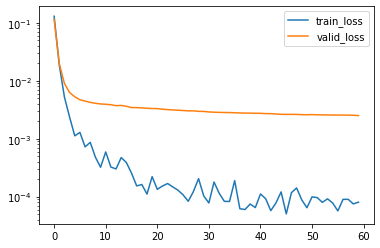

In [6]:
net, train_loss_history, valid_loss_history,dict_name = trainSiamese(net,criterion,optimizer,scheduler,train_dataloader,
             valid_dataloader,config.train_number_epochs,do_show=True)

## Testing

../../datasets/AT&T Database of Faces/faces/testing/siamese_test_data.csv


100%|████████████████████████████████████████| 359/359 [00:01<00:00, 230.99it/s]


+1/-1 ratrio:0.50/0.50
+1 features max:0.80	 min:0.04	 mean:0.17	 median 0.13
-1 features max:0.81	 min:0.15	 mean:0.29	 median 0.27
Feature = 0	Threshold = 0.197482	Polorization = 1
Test loss: 0.0260	 Test error: 0.1727


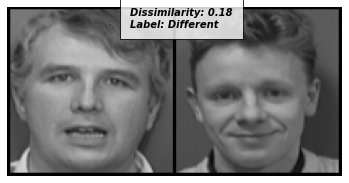

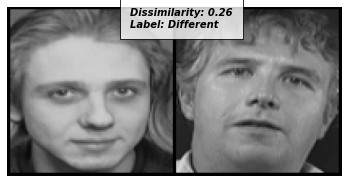

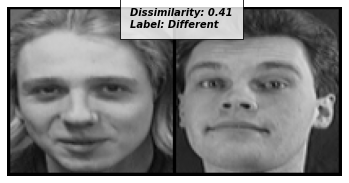

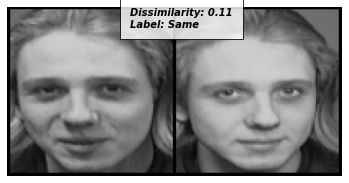

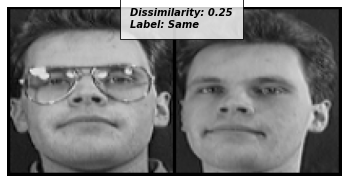

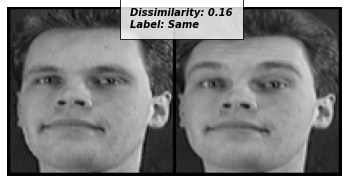

In [7]:
net = SiameseNetwork().cuda()
net.load_state_dict(torch.load(os.path.join("state_dict",dict_name)))
net.eval()

siamese_test = SiameseNetworkDataset(config.siamese_testing_csv,
                                        transform=transforms.Compose([transforms.Resize((config.img_height,config.img_width)),
                                                                      transforms.ToTensor(),
                                                                      transforms.Normalize(0,1)
                                                                      ])
                                       ,should_invert=False)
test_dataloader = DataLoader(siamese_test,num_workers=8,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)

test_loss, test_er = inferenceSiamese(net,criterion,test_dataloader)
print("Test loss: %.4f\t Test error: %.4f"
      %(test_loss, test_er))


for i in range(3):
    label = 0
    while label == 0:
        x0,x1,label = next(dataiter)
        label = label.detach().cpu().numpy()[0][0]

    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}\nLabel: {}'.format(euclidean_distance.item(),'Different'))

for i in range(3):
    label = 1
    while label == 1:
        x0,x1,label = next(dataiter)
        label = label.detach().cpu().numpy()[0][0]

    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}\nLabel: {}'.format(euclidean_distance.item(),'Same'))



In [8]:
dict_name

'Adam lr-3.13e-05 wd-0.00e+00 bs-128 train_loss-8.07e-05 valid_loss-2.51e-03 valid_error-0.00e+00.pth'